## Image generation pipeline

In [ ]:
from diffusers import AutoPipelineForText2Image
from diffusers.utils import load_image
import torch

In [ ]:
pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", 
    torch_dtype=torch.float16
).to("cuda")

pipe.load_ip_adapter(
    "h94/IP-Adapter", 
    subfolder="sdxl_models", 
    weight_name="ip-adapter_sdxl_vit-h.safetensors", 
    torch_dtype=torch.float16
)

pipe.set_ip_adapter_scale(1)

Here we suppose that we obtain `image_embeds` as follows:
1. Pass fMRI through the fMRI encoder to get `fmri_embeds`
2. Pass EEG through the EEG encoder to get `eeg_embeds`
3. Pass `fmri_embeds` and `eeg_embeds` through fuse module to get `combined_embeds`

`combined_embeds` should be the same dim, as CLIP-ViT-H-14 embedding, i.e. 1024

In [ ]:
# but here we just set it randomly
combined_embeds = torch.randn(1, 1024).to(torch.float16) # vector of dim 1024

In [ ]:
ip_adapter_image_embeds = torch.cat([
    torch.zeros_like(combined_embeds),
    combined_embeds
]).unsqueeze(1)

image = pipe(
    prompt='', 
    ip_adapter_image_embeds=[ip_adapter_image_embeds], 
    num_inference_steps=30,
    guidance_scale=5.0,
).images[0]

image

---

## Example of image reconstruction with CLIP-ViT-H-14 and SDXL + IP-Adapter

In [1]:
from diffusers import AutoPipelineForText2Image
from diffusers.utils import load_image
import torch

/home/jovyan/.mlspace/envs/visual_stimuli/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", 
    torch_dtype=torch.float16
).to("cuda")

pipe.load_ip_adapter(
    "h94/IP-Adapter", 
    subfolder="sdxl_models", 
    weight_name="ip-adapter_sdxl_vit-h.safetensors", 
    torch_dtype=torch.float16
)

pipe.set_ip_adapter_scale(1)

Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


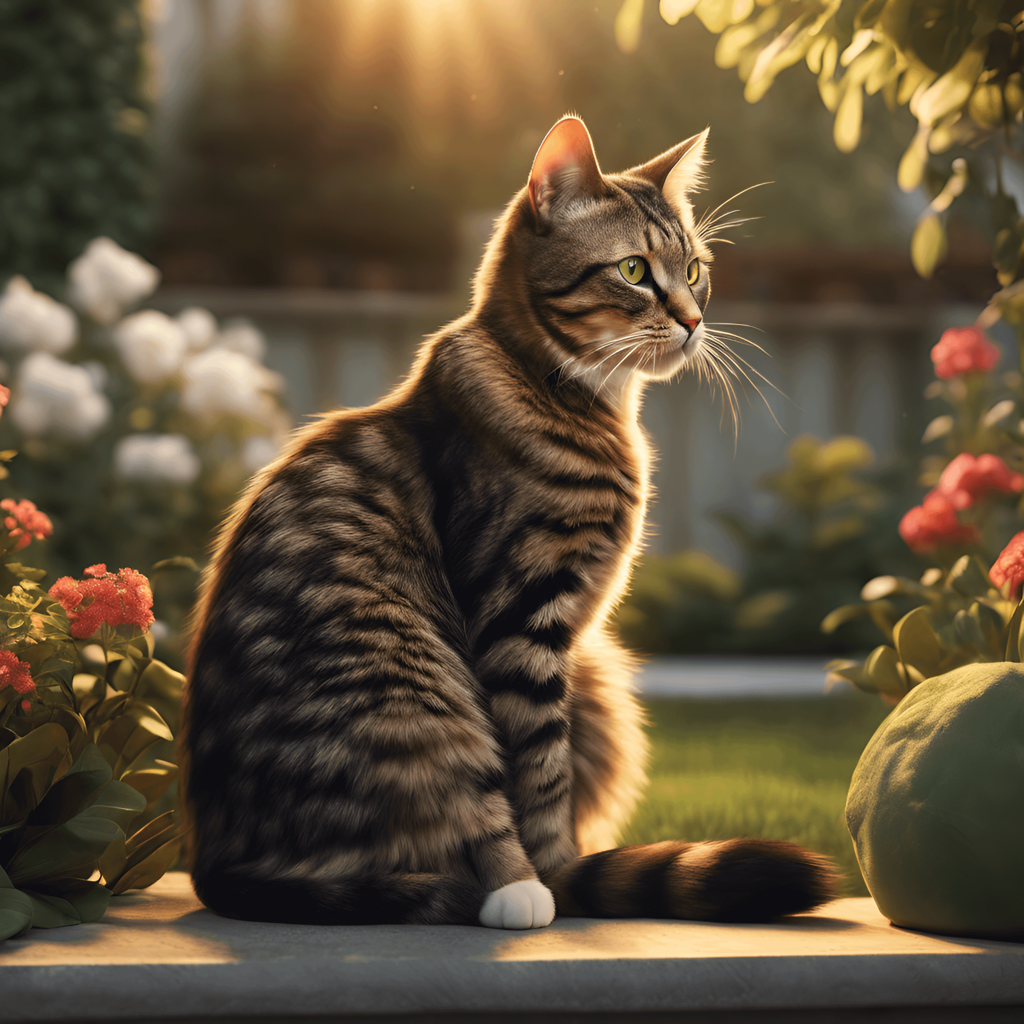

In [4]:
image = load_image('https://preview.redd.it/sdxl-is-really-good-with-cats-v0-n7izni8y1f9c1.png?auto=webp&s=d939d6d86f4402e0ea588faf3ca86d67903a826c')
image = image.resize((1024, 1024))
image

In [8]:
import open_clip

image_encoder, _, feature_extractor = open_clip.create_model_and_transforms(
    'ViT-H-14', pretrained='laion2b_s32b_b79k', precision='fp16', device='cuda')

In [9]:
image_processed = feature_extractor(image)[None, ...].to("cuda", dtype=torch.float16)
image_embeds = image_encoder.encode_image(image_processed)

100%|██████████| 30/30 [00:03<00:00,  9.04it/s]


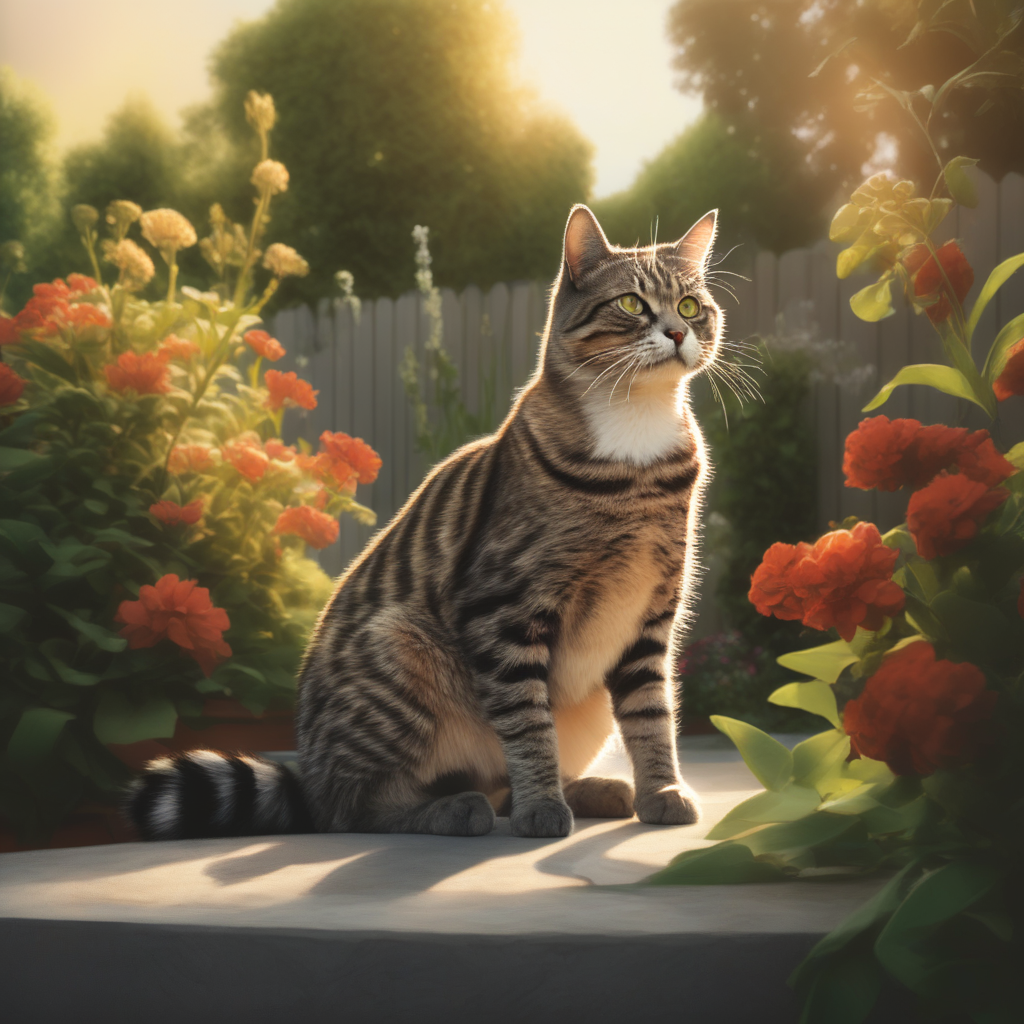

In [11]:
ip_adapter_image_embeds = torch.cat([
    torch.zeros_like(image_embeds),
    image_embeds
]).unsqueeze(1)

image = pipe(
    prompt='', 
    ip_adapter_image_embeds=[ip_adapter_image_embeds], 
    num_inference_steps=30,
    guidance_scale=5.0,
).images[0]

image